In [54]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

## Reading and Processing the Data

In [55]:
oracle_df = pd.read_csv("ORCL_NYSE_Oracle Corporation.csv")
pirelli_df = pd.read_csv("PIRC.MI_Borsa Italiana_PIRELLI & C.csv")
pirelli_df = pirelli_df.drop(columns=["Open_EUR", "High_EUR", "Low_EUR", "Close_EUR", "Volume_EUR", "FX"])

In [56]:
oracle_df["Date"] = pd.to_datetime(oracle_df["Date"])
pirelli_df["Date"] = pd.to_datetime(pirelli_df["Date"])

We base our analysis on the last 5 years historical data of Oracle's and Pirelli's stocks.

In [57]:
oracle_df = oracle_df.loc[oracle_df["Date"] > pd.to_datetime("2020-02-02")]
pirelli_df = pirelli_df.loc[pirelli_df["Date"] > pd.to_datetime("2020-02-02")]

In [58]:
oracle_df.index = [i for i in range(len(oracle_df))]
pirelli_df.index = [i for i in range(len(pirelli_df))]

In [59]:
# Filter rows where the Date in pirelli_df is not in oracle_df or the Date in oracle_df is not in pirelli_df
pirelli_df = pirelli_df[pirelli_df["Date"].isin(oracle_df["Date"].values)].reset_index(drop=True)
oracle_df = oracle_df[oracle_df["Date"].isin(pirelli_df["Date"].values)].reset_index(drop=True)

### Estimating the Expected Daily Returns and Risk (standard deviation)

The following fucntion calculates the rate of change or return of a stock using its close price for a specific window of time. We are interested in the daily returns of both stocks so we use a window to 1.

In [60]:
def calculate_returns(data, window=1):
    returns = (data["Close_USD"] - data["Close_USD"].shift(window)) / data["Close_USD"].shift(window)
    for i in range(window):
        if i == 0:
            returns[i] = (data["Close_USD"][i] - data["Open_USD"][i]) / data["Open_USD"][i]
        else:
            returns[i] = (data["Close_USD"][i] - data["Close_USD"][0]) / data["Close_USD"][0]
    return returns

In [61]:
oracle_returns = calculate_returns(oracle_df)
pirelli_returns = calculate_returns(pirelli_df)

Since the mean is an unbiased estimator of the expectation, we estimate the **expected daily return** for each stock (Oracle, Pirelli) using the average of its daily returns over the past 5 years: $$\text{Expected Daily Return} = \mu = \frac{1}{n}\sum_{i=1}^n DailyReturn_i$$ $$\text{Risk} = \sigma =\sqrt{\frac{1}{n} \sum_{i=1}^n (DailyReturn_i - Expected Daily Return)^2}$$ The associated **risk** for each stock is estimated using the standard deviation of its daily returns.

In [62]:
oracle_expected_return = np.mean(oracle_returns)
oracle_std = np.std(oracle_returns)
print(f"For Oracle, the estimated expected daily return and risk are {oracle_expected_return} and {oracle_std} respectively.")
print(f"95% of the last 5 years daily returns lay on the interval [{oracle_expected_return - 2*oracle_std}, {oracle_expected_return + 2*oracle_std}]")
print("---------------------------------------------------------------------------------------")
pirelli_expected_return = np.mean(pirelli_returns)
pirelli_std = np.std(pirelli_returns)
print(f"For Pirelli, the estimated expected daily return and risk are {pirelli_expected_return} and {pirelli_std} respectively.")
print(f"95% of the last 5 years daily returns lay on the interval [{pirelli_expected_return - 2*pirelli_std}, {pirelli_expected_return + 2*pirelli_std}]")

For Oracle, the estimated expected daily return and risk are 0.0009990309841320377 and 0.022007608468017373 respectively.
95% of the last 5 years daily returns lay on the interval [-0.04301618595190271, 0.04501424792016678]
---------------------------------------------------------------------------------------
For Pirelli, the estimated expected daily return and risk are 0.00047442162419435895 and 0.022367019169367904 respectively.
95% of the last 5 years daily returns lay on the interval [-0.04425961671454145, 0.045208459962930166]


Another important metric is the **annualized expected return**, which represents the compounded return over a year assuming daily investments are continuously reinvested.

In [63]:
oracle_annualized_exp_return = oracle_expected_return * 252
oracle_annualized_std = oracle_std * np.sqrt(252)
print(f"For Oracle, the estimated expected annualized return and risk are {oracle_annualized_exp_return} and {oracle_annualized_std} respectively.")
print("---------------------------------------------------------------------------------------")

pirelli_annualized_exp_return = pirelli_expected_return * 252
pirelli_annualized_std = pirelli_std * np.sqrt(252)
print(f"For Pirelli, the estimated expected annualized return and risk are {pirelli_annualized_exp_return} and {pirelli_annualized_std} respectively.")

For Oracle, the estimated expected annualized return and risk are 0.2517558080012735 and 0.34935995374591894 respectively.
---------------------------------------------------------------------------------------
For Pirelli, the estimated expected annualized return and risk are 0.11955424929697846 and 0.3550654217517718 respectively.


We use the daily returns of each stock to construct the covariance matrix $\boldsymbol{\Sigma}$ where the covariance is calculated using: $$\text{Cov}(X, Y) = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})$$ 
$X_i = \text{Daily return of Oracle at time } i$  
$Y_i = \text{Daily return of Pirelli at time } i$  
$\bar{X} = \text{Expected Daily Return of Oracle}$  
$\bar{Y} = \text{Expected Daily Return of Pirelli}$ 

The diagonal elements of the covariance matrix represent the variances associated with each stock, while the off-diagonal elements represent the covariances between pairs of stocks.


In [64]:
covariance_matrix = np.cov(oracle_returns, pirelli_returns)
print("The covariance matrix is:")
print(covariance_matrix)

The covariance matrix is:
[[0.00048471 0.00010931]
 [0.00010931 0.00050067]]


## Constructing the optimal portfolio 

In this section, we simulate a set of portfolios with two main assumptions: 
- All long positions (no short selling and negative weights).
- The weights are between 0 and 1 (No leveraging).

Since we have only two stocks, we construct possible portfolios by varying $w_{\text{oracle}}$, the weight of Oracle, from 0 to 1. The weight of Pirelli, $w_{\text{pirelli}}$, is then computed as $1 - w_{\text{oracle}}$. The weights are used to compute the portofolios' risk and expected return $(\sigma_{p}, \mu_{p})$ to plot the **feasible region** of portfolios where: $$\mu_{p} = \mathbf{w} \cdot \boldsymbol{\mu} = \mu_{oracle}w_{oracle} + \mu_{pirelli}w_{pirelli}$$ $$\sigma_{p} = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = \sqrt{w_{oracle}^2 \sigma_{oracle}^2 + w_{pirelli}^2 \sigma_{pirelli}^2 + 2 w_{oracle} w_{pirelli} \text{Cov}(oracle, pirelli)}$$
Additionaly, for each portfolio we compute its **sharpe ratio** which is equal to the risk premium to the standard deviation of the portfolio: $$\text{Sharpe Ratio} = \frac{\mu_{p} - \mu_{f}}{\sigma_{p}}$$
Assuming the annual risk free rate to be equal to **2%** we calculate the daily risk free rate to **0.02/252**.

In [65]:
expected_returns = np.array([oracle_expected_return, pirelli_expected_return])
risk_free_rate = 0.02 / 252

all_weights = []
return_array = []
risk_array = []
sharpe_array = []

possible_weights = [i / 10000 for i in range(10001)]
for w in possible_weights:
    weights = np.array([w, 1 - w])
    all_weights.append(weights)
    expected_return = expected_returns @ weights.T
    return_array.append(expected_return)
    volatility = np.sqrt(weights.T @ covariance_matrix @ weights)
    risk_array.append(volatility)
    sharpe_array.append((expected_return - risk_free_rate) / volatility)

return_array = np.array(return_array)
risk_array = np.array(risk_array)
sharpe_array = np.array(sharpe_array)

C:\Users\abaha\AppData\Local\Temp\ipykernel_22416\882231049.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(labelspacing=0.8)


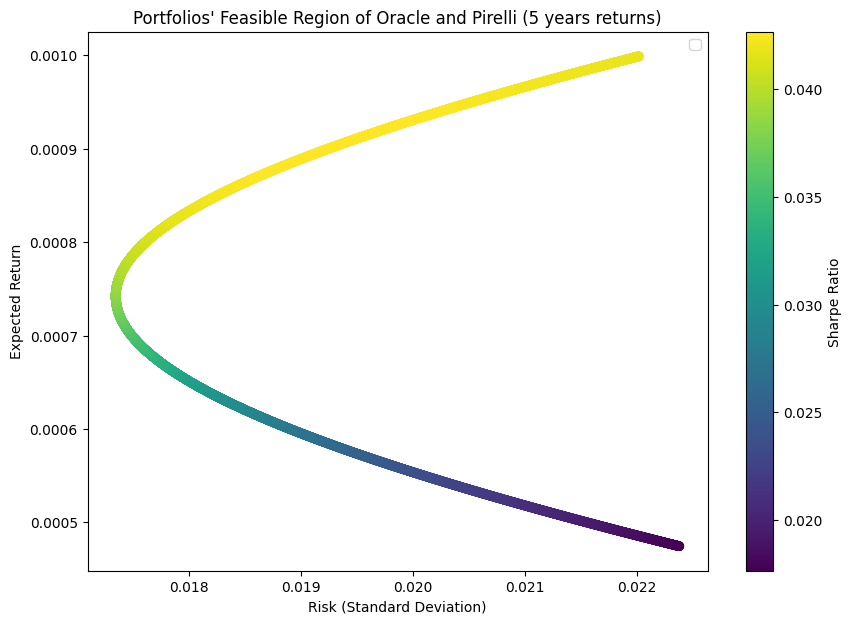

In [66]:
plt.figure(figsize=(10, 7))
plt.scatter(risk_array, return_array, c=sharpe_array, cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio', cmap='viridis')
plt.title("Portfolios' Feasible Region of Oracle and Pirelli (5 years returns)")
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)

The figure above shows the **feasible region** for the possible portfolios that can be constructed without short-selling or leveraging. The **efficient frontier** is the **upper portion** of the curve. It includes the portfolios with **maximum return** for a given **risk**. 

### Minimum Variance Portfolio

The **minimum variance portfolio** is the portfolio with the minimal risk (standard deviation).

In [67]:
min_risk_idx = risk_array.argmin()
min_risk_weights = all_weights[min_risk_idx]

print(f"The weights for the portfolio with lowest risk are: {min_risk_weights}.")
print(f"The expected return of the minimum variance portfolio is: {return_array[min_risk_idx]}")
print(f"The risk of the minimum variance portfolio is: {risk_array[min_risk_idx]}")

The weights for the portfolio with lowest risk are: [0.5104 0.4896].
The expected return of the minimum variance portfolio is: 0.0007421822415065502
The risk of the minimum variance portfolio is: 0.017346961795813184


### Maximal Sharpe Ratio Portfolio

Another important portfolio to analyse is the one with the maximum value for the sharpe ration.

In [68]:
max_sharpe_idx = sharpe_array.argmax()
max_sharpe_risk = risk_array[max_sharpe_idx]
max_sharpe_return = return_array[max_sharpe_idx]
max_sharpe_weights = all_weights[max_sharpe_idx]

print(f"The weights for the portfolio that maximizes the Sharpe ratio are: {max_sharpe_weights}.")
print(f"The expected return of the maximum sharpe ratio portfolio is: {max_sharpe_return}")
print(f"The risk of the maximum sharpe ratio portfolio is: {max_sharpe_risk}")

The weights for the portfolio that maximizes the Sharpe ratio are: [0.821 0.179].
The expected return of the maximum sharpe ratio portfolio is: 0.0009051259087031932
The risk of the maximum sharpe ratio portfolio is: 0.019361937810152836


The figure below shows the feasible region of portfolios, highlighting the minimum variance portfolio, the maximum Sharpe ratio portfolio, and the portfolios where all capital is invested in either Oracle or Pirelli. 

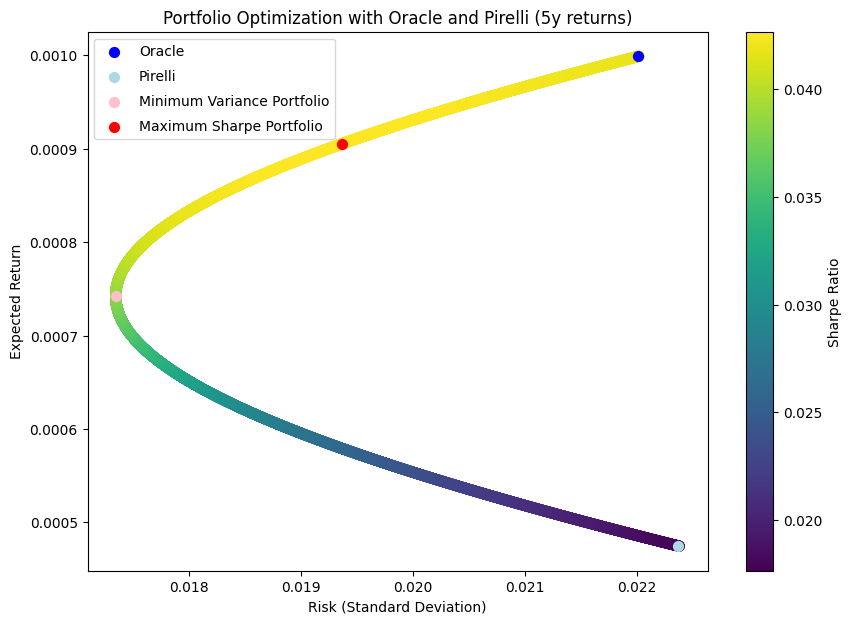

In [69]:
min_var_idx = np.argmin(risk_array)
min_var_vol = risk_array[min_var_idx]
min_var_ret = return_array[min_var_idx]

plt.figure(figsize=(10, 7))
plt.scatter(risk_array, return_array, c=sharpe_array, cmap='viridis', s=50, marker='o')
plt.colorbar(label='Sharpe Ratio', cmap='viridis')
plt.scatter(oracle_std, oracle_expected_return, color='blue', s=50, label='Oracle')
plt.scatter(pirelli_std, pirelli_expected_return, color='lightblue', s=50, label='Pirelli')
plt.scatter(min_var_vol, min_var_ret, color='pink', s=50, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_risk, max_sharpe_return, color='red', s=50, label='Maximum Sharpe Portfolio')
plt.title('Portfolio Optimization with Oracle and Pirelli (5y returns)')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)

### The Efficient Frontier

The Efficient Frontier consists of portfolios that achieve the minimum risk (variance) for a given level of expected return. To construct it, we solve the following optimization problem using the Lagrangian method: $$\begin{aligned}& \min_{\mathbf{w}} \quad && \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w} \\ & \text{subject to} \quad && \mathbf{w}^\top \mathbf{1} = 1 \\ & && \mathbf{w} ^\top \mathbf{\mu} = \mu_{p} \end{aligned}$$ where: 
- $\mathbf{w}$: vector of portfolio weights (in this case $w_{oracle}$ and $w_{pirelli}$).
- $\boldsymbol{\Sigma}$: covariance matrix of the stocks.
- $\mu$: vector of the estimated expected daily returns of both stocks.
- $\mathbf{1}$: vector of ones (ensures the sum of weights equals 1).
- $\mu_{p}$: desired portfolio return.
  
The solution of this optimization problem is given by:
$$\mathbf{w} = f_1  + f_2 \cdot \mu_{p}$$
where: 
- $\begin{aligned} f_1 &= \frac{A_2}{A_4} \mathbf{1}^\top \boldsymbol{\Sigma}^{-1} - \frac{A_1}{A_4} \boldsymbol{\mu}^\top \boldsymbol{\Sigma}^{-1}\end{aligned}$
- $\begin{aligned}f_2 &= \frac{A_3}{A_4} \boldsymbol{\mu}^\top \boldsymbol{\Sigma}^{-1} - \frac{A_1}{A_4} \mathbf{1}^\top \boldsymbol{\Sigma}^{-1} \end{aligned}$

and:
- $\begin{aligned} A_1 &= \mathbf{1} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}^\top \end{aligned}$
- $\begin{aligned} A_2 &= \boldsymbol{\mu} \boldsymbol{\Sigma}^{-1} \boldsymbol{\mu}^\top \end{aligned}$ 
- $\begin{aligned} A_3 &= \mathbf{1} \boldsymbol{\Sigma}^{-1} \mathbf{1}^\top \end{aligned}$ 
- $\begin{aligned}A_4 &= A_2 A_3 - A_1^2 \end{aligned}$

Since we assume all long positions (no short selling) and portfolio weights between 0 and 1, and given that the expected returns of the feasible portfolios lie approximately between 0.0004 (0.04%) and 0.001 (0.1%), we compute $\mathbf{w}$ using the formula above for all possible portfolio returns $\mu_{p}$ within this range.

In [70]:
inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
print("The inverse of the covariance matrix:")
print(inverse_covariance_matrix)

The inverse of the covariance matrix:
[[2169.92599993 -473.75079515]
 [-473.75079515 2100.75016186]]


In [71]:
desired_returns = np.arange(0.0004, 0.001, 0.000001)
ones_vector = np.ones(2)
expected_returns = np.array([oracle_expected_return, pirelli_expected_return])

a1 = ones_vector @ inverse_covariance_matrix @ expected_returns.T
a2 = expected_returns @ inverse_covariance_matrix @ expected_returns.T
a3 = ones_vector @ inverse_covariance_matrix @ ones_vector.T
a4 = (a2 * a3) - (a1 ** 2)

f1 = (a2 / a4) * (ones_vector @ inverse_covariance_matrix) - (a1 / a4) * (expected_returns @ inverse_covariance_matrix)
f2 = (a3 / a4) * (expected_returns @ inverse_covariance_matrix) - (a1 / a4) * (ones_vector @ inverse_covariance_matrix)

efficient_frontier = {}
for desired_return in desired_returns:
    efficient_frontier[desired_return] = f1 + f2 * desired_return

For expected return $\mu_{p}$ we compute the risk associated with it using its corresponding weights. Using the same formula as before: $$\sigma_{p} = \sqrt{\mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}} = \sqrt{w_{oracle}^2 \sigma_{oracle}^2 + w_{pirelli}^2 \sigma_{pirelli}^2 + 2 w_{oracle} w_{pirelli} \text{Cov}(oracle, pirelli)}$$

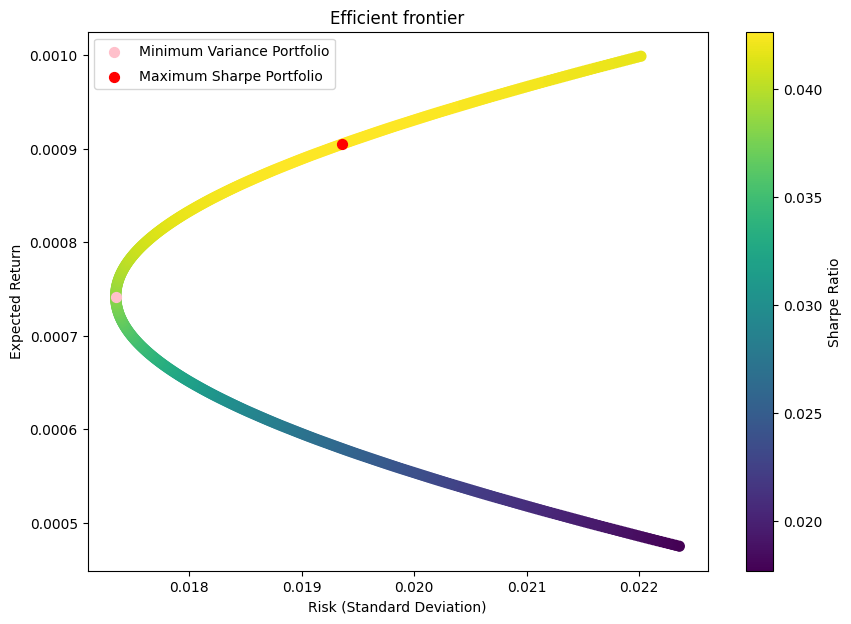

In [72]:
pairs_mean_var = {}
sharpe_ratios_eff = {}
for i in efficient_frontier:
    if efficient_frontier[i][0] >= 0 and efficient_frontier[i][1] >= 0 and efficient_frontier[i][0] <= 1 and efficient_frontier[i][1] <=1:
        pairs_mean_var[i] = np.sqrt(efficient_frontier[i] @ covariance_matrix @ efficient_frontier[i].T)
        sharpe_ratios_eff[i] = (i - risk_free_rate) / pairs_mean_var[i]
array_ratios = np.array(list(sharpe_ratios_eff.values()))

min_risk_return = min(pairs_mean_var, key=pairs_mean_var.get)
min_risk_value = pairs_mean_var[min_risk_return]

max_sharpe_return = max(sharpe_ratios_eff, key=sharpe_ratios_eff.get)
max_sharpe_risk = pairs_mean_var[max_sharpe_return]

portfolio_expected_returns = pairs_mean_var.keys()
portfolio_risk = pairs_mean_var.values()

plt.figure(figsize=(10,7))
plt.scatter(portfolio_risk, portfolio_expected_returns, c=array_ratios, cmap='viridis', s=50, marker='o')
plt.colorbar(label='Sharpe Ratio', cmap='viridis')
plt.scatter(min_risk_value, min_risk_return, color='pink', s=50, label='Minimum Variance Portfolio')
plt.scatter(max_sharpe_risk, max_sharpe_return, color='red', s=50, label='Maximum Sharpe Portfolio')
plt.title('Efficient frontier')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend(labelspacing=0.8)

In [73]:
print(f"The weights for the portfolio with lowest risk are: {efficient_frontier[min_risk_return]}.")
print(f"The expected return of the minimum variance portfolio is: {min_risk_return}")
print(f"The risk of the minimum variance portfolio is: {min_risk_value}")

The weights for the portfolio with lowest risk are: [0.51005261 0.48994739].
The expected return of the minimum variance portfolio is: 0.0007420000000000083
The risk of the minimum variance portfolio is: 0.0173469645871659


In [74]:
print(f"The weights for the portfolio that maximizes the Sharpe ratio are: {efficient_frontier[max_sharpe_return]}.")
print(f"The expected return of the maximum sharpe ratio portfolio is: {max_sharpe_return}")
print(f"The risk of the maximum sharpe ratio portfolio is: {max_sharpe_risk}")

The weights for the portfolio that maximizes the Sharpe ratio are: [0.82076 0.17924].
The expected return of the maximum sharpe ratio portfolio is: 0.0009050000000000123
The risk of the maximum sharpe ratio portfolio is: 0.019358986687361034


The weights of the minimum variance and maximum Sharpe ratio portfolios on the efficient frontier are approximately the same as those previously identified in the feasible region. In fact, the first figure appears to depict the efficient frontier rather than the entire feasible region. This is due to the restriction of portfolio weights to lie between 0 and 1 and the fact that we are only considering two assets. If we allowed a broader range of expected portfolio returns, and thus permitted weights outside the [0, 1] interval, the feasible region would differ significantly from the efficient frontier.

### Conclusion and Results

In [77]:
min_risk_oracle = round(efficient_frontier[min_risk_return][0], 3)
min_risk_pirelli = round(efficient_frontier[min_risk_return][1], 3)
max_sharpe_oracle = round(efficient_frontier[max_sharpe_return][0], 3)
max_sharpe_pirelli = round(efficient_frontier[max_sharpe_return][1], 3)
d = {
    'Oracle': [f"{round(oracle_expected_return * 100, 3)}%", f"{round(oracle_std * 100, 3)}%", np.array([1, 0])],
    'Pirelli': [f"{round(pirelli_expected_return* 100, 3)}%", f"{round(pirelli_std * 100, 3)}%", np.array([0, 1])],
    'Minimum Variance Portfolio': [f"{round(min_risk_return * 100, 2)}%",f"{round(min_risk_value * 100, 3)}%", [min_risk_oracle, min_risk_pirelli]],
    'Maximum Sharpe Ratio Portfolio': [f"{round(max_sharpe_return * 100, 2)}%",f"{round(max_sharpe_risk * 100, 3)}%", [max_sharpe_oracle, max_sharpe_pirelli]],
}

df = pd.DataFrame(d, index=['Return', 'Risk', "Weights"])
display(df)

,Oracle,Pirelli,Minimum Variance Portfolio,Maximum Sharpe Ratio Portfolio
Return,0.1%,0.047%,0.07%,0.09%
Risk,2.201%,2.237%,1.735%,1.936%
Weights,"[1, 0]","[0, 1]","[0.51, 0.49]","[0.821, 0.179]"


The portfolio that yields the highest expected daily return is the one where we fully invest in Oracle. However, this portfolio also carries a higher level of risk compared to the minimum variance and maximum Sharpe ratio portfolios. On the other hand, investing fully in Pirelli is the least favorable option, as it results in both a low expected daily return and the highest risk. For risk-averse investors, the minimum variance portfolio is the preferred choice, as it minimizes volatility. Conversely, for risk-seeking investors, the optimal portfolio would be the one with the maximum Sharpe ratio, as it offers a return close to the highest possible, but with moderately low risk.